# ISSR 

Model ice super-saturated regions (ISSR) of the atmosphere.

### Met Data

- Requires account with [Copernicus Data Portal](https://cds.climate.copernicus.eu/cdsapp#!/home) and  local `~/.cdsapirc file` with credentials.

In [1]:
# ignore pycontrails warning about ECMWF humidity scaling
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

from pycontrails import Flight
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.models.issr import ISSR

warnings.filterwarnings(message=r"[\s\S]* humidity scaling [\s\S]*", action="ignore")

## Get Data

In [2]:
time = ("2022-03-01 00:00:00", "2022-03-01 08:00:00")
pressure_levels = [300, 250, 200]
variables = ["t", "q"]

In [3]:
era5 = ERA5(time=time, variables=variables, pressure_levels=pressure_levels)
met = era5.open_metdataset()

## Evaluate model

In [4]:
# run model for across full input domain
# outputs global ice super-saturated regions as 1.0, all other regions as 0.0
issr_mds = ISSR(met).eval()
issr = issr_mds["issr"]

In [5]:
# edge detection algorithm using differentiation to reduce the areas to lines
issr_edges = issr.find_edges()

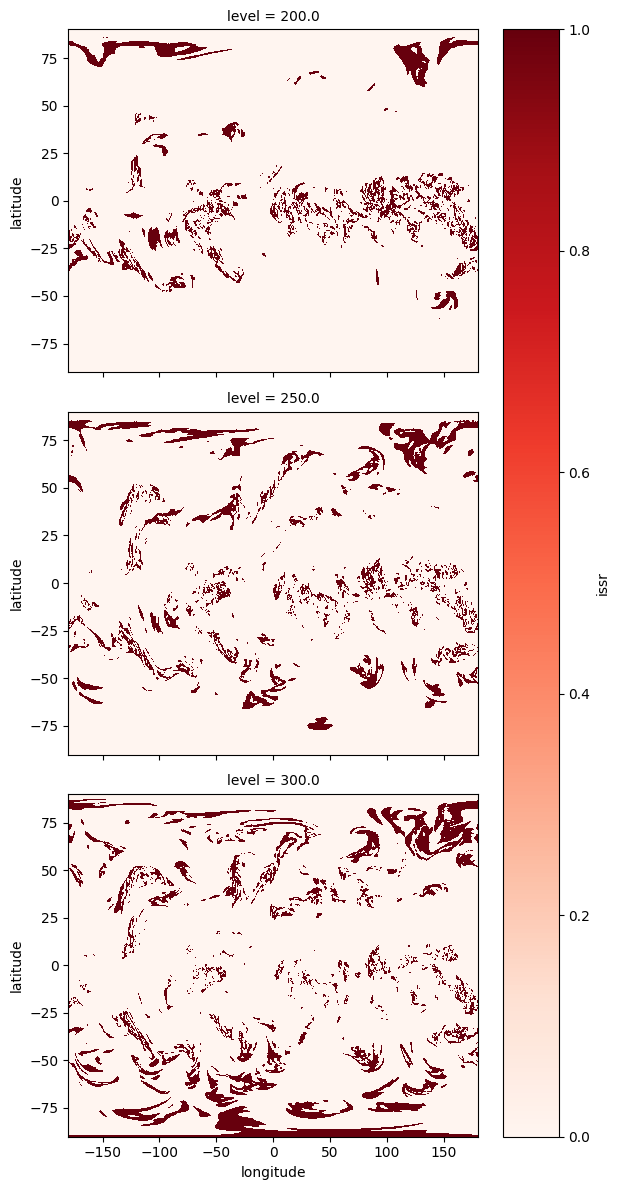

In [6]:
da = issr.data.isel(time=0)
da.plot(x="longitude", y="latitude", row="level", cmap="Reds", figsize=(6, 12));

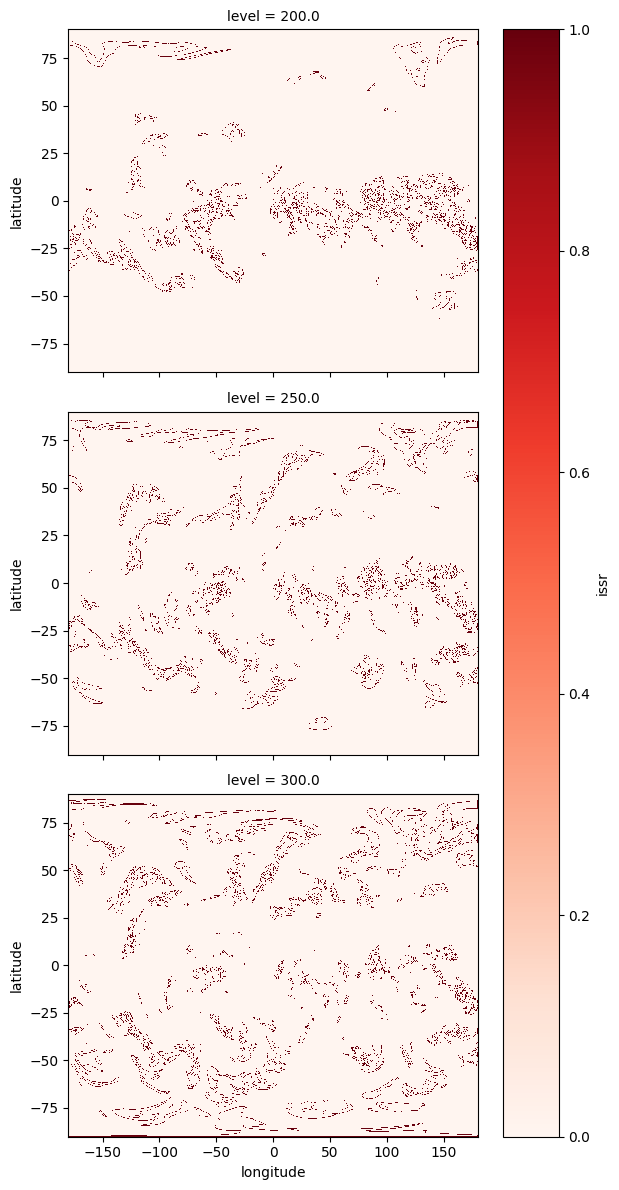

In [7]:
# plot issr edges for each pressure level
da = issr_edges.data.isel(time=0)
da.plot(x="longitude", y="latitude", row="level", cmap="Reds", figsize=(6, 12));

## Interpolate

Run model along a flight path

In [8]:
# Load flight
df = pd.read_csv("data/flight.csv", parse_dates=["time"])
fl = Flight(data=df, flight_id="acdd1b", callsign="AAL1158")

fl

Flight [4 keys x 175 length, 3 attributes]
	Keys: longitude, latitude, altitude, time
	Attributes:
	time                [2022-03-01 00:50:00, 2022-03-01 03:47:00]
	longitude           [-97.026, -77.036]
	latitude            [32.931, 38.854]
	altitude            [190.5, 11582.4]
	flight_id           acdd1b
	callsign            AAL1158
	crs                 EPSG:4326

In [9]:
# run model for across full input domain
# outputs global ice super-saturated regions as 1, all other regions as 0
# np.nan is returned outside of the met domain
fl_out = ISSR(met=met).eval(source=fl)
fl_out["issr"]

array([nan, nan,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1., nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan])

In [10]:
# Get the length of the Flight in the ISSR region
fl_out.length_met("issr")

190812.60842238227

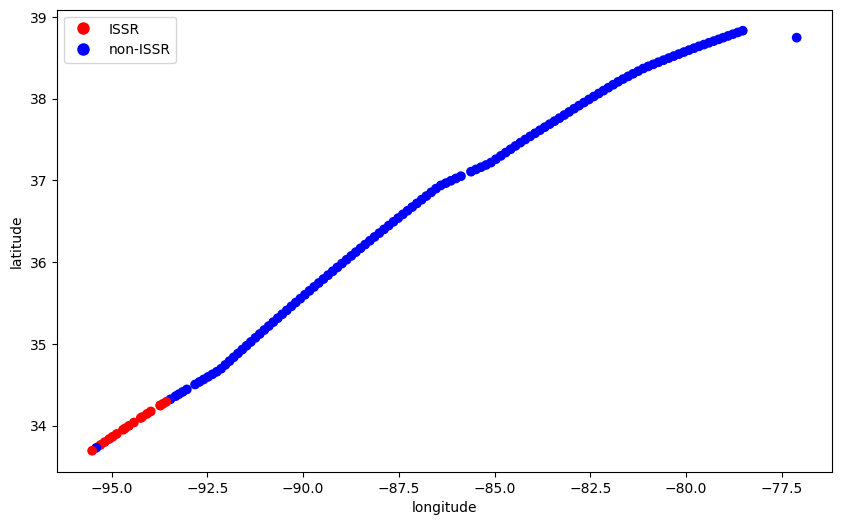

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create colormap with red for ISSR and blue for non-ISSR
cmap = ListedColormap(["b", "r"])

ax.scatter(fl_out["longitude"], fl_out["latitude"], c=fl_out["issr"], cmap=cmap)


# Create legend
legend_elements = [
    plt.Line2D([0], [0], marker="o", color="w", label="ISSR", markerfacecolor="r", markersize=10),
    plt.Line2D(
        [0], [0], marker="o", color="w", label="non-ISSR", markerfacecolor="b", markersize=10
    ),
]
ax.legend(handles=legend_elements, loc="upper left")

ax.set(xlabel="longitude", ylabel="latitude");